# **TP3 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema - Sistema de Travagem ABS**
No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
    Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


4. Faça
    1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
    2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
        2. “a velocidade $V$ diminui sempre com o tempo”.
    3. Codifique em SMT’s o modelo que definiu em a.
    4. Codifique a verificação das propriedades temporais que definiu em b.

<img src="esquema.png" style="width:700px;height:400px"/>

**Equações de Fluxo** 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.
5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,

$$\begin{array}{c} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$   

e , no modo `Blocked`,  a dinâmica do sistema é  regida por

$$
\begin{array}{c} (V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,) \end{array} $$


6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

## Constantes e variaveis  do sistema
**Constantes:**<br>
> $a$ ⟶ atrito do ar<br>
> $b$ ⟶ atrito do solo<br>
> $c1$ ⟶ constante de proporcionalidade na travagem do modo `Free`<br>
> $c2$ ⟶ constante de proporcionalidade na travagem do modo `Stopping`<br>
> $e$ ⟶ $Min(V - R)$ do modo `Stopping` que quando ultrapassado obriga à transição de modo<br>
> $P$ ⟶ peso em kilogramas do veículo<br>
> $tau \ (τ)$ ⟶ tempo em segundos de cada execução dos modos `Blocked` e `Free`<br>
> $time$ ⟶ tempo maximo em segundos até o veículo se imobilizar<br>
> $vi$ ⟶ velocidade inicial do veículo em metros/segundo



**Variaveis continuas:**<br>
> $T$ ⟶ tempo em segundos<br>
> $V$ ⟶ velocidade do veiculo em metros/segundo<br>
> $R$ ⟶ velocidade das rodas em metros/segundo(v)<br>
> $Timer$ ⟶ Timer utilizado nos modos Free e Blocked

**Variaveis Discretas:**<br>
> $M$ ⟶ Modo



In [1]:
from z3 import *
import pygraphviz as pgv
from IPython.display import Image 
import matplotlib.pyplot as plt

## A. Autómato híbrido que descreve a dinâmica do sistema

### Função para desenhar o autómato

In [2]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

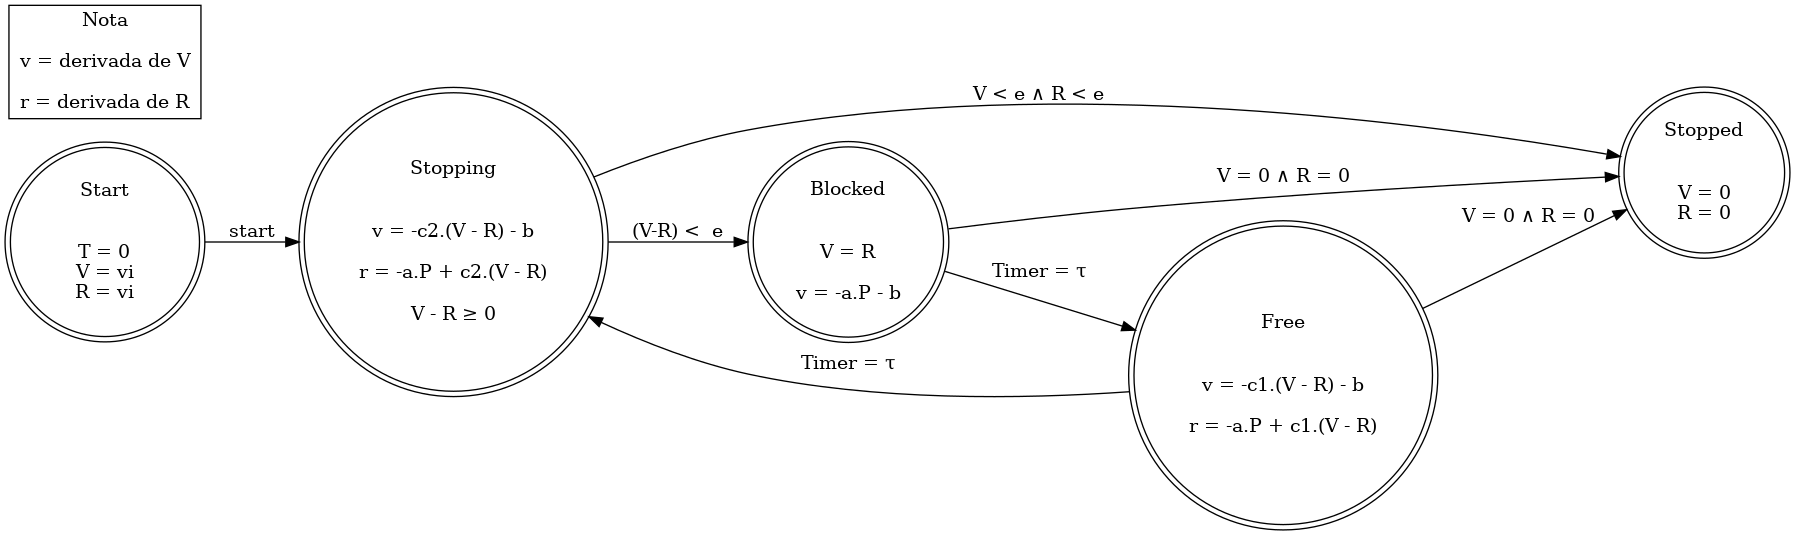

In [24]:
ABS = """digraph{
    rankdir=LR;
    Start [shape=doublecircle, label="Start\n\n\nT = 0\nV = vi\nR = vi"];
    Free [shape = doublecircle, label="Free\n\n\nv = -c1.(V - R) - b\n\nr = -a.P + c1.(V - R)"];
    Stopping [shape = doublecircle, label="Stopping\n\n\nv = -c2.(V - R) - b\n\nr = -a.P + c2.(V - R)\n\nV - R ≥ 0"];
    Blocked [shape = doublecircle, label="Blocked\n\n\nV = R\n\nv = -a.P - b"];
    Stopped [shape = doublecircle, label="Stopped\n\n\nV = 0\nR = 0"];
    
    Nota [shape=box, label="Nota\n\nv = derivada de V\n\nr = derivada de R"];
  
    Start -> Stopping[label="start"];
    Free -> Stopping [label="Timer = τ"];
    Stopping -> Blocked[label="(V-R) <  e"];
    Stopping -> Stopped[label="V < e ∧ R < e"];
    Blocked -> Free [label="Timer = τ"];
    Blocked -> Stopped[label="V = 0 ∧ R = 0"];
    Free -> Stopped[label="V = 0 ∧ R = 0"];  
}"""

draw(ABS)

## B. Modelação em LT das propriedades que garantem comportameneto desejável
### a. ”o veículo imobiliza-se completamente em menos de $t$ segundos”.<br>
> $T \ge t \quad \implies\ \quad M = Stopped$

### b. “a velocidade $V$ diminui sempre com o tempo”.
> $ t' > t \quad \implies\ \quad V' < V$


## Codificação do Modelo

### Enumeração dos modos

In [32]:
Mode,(START, FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING', 'BLOCKED','STOPPED'))

### Função que mostra o grafico de evolução do sistema em função das constantes

Nesta função é feita uma simulação de execução do sistema com base nas equações fornecidas no enunciado e com o valor das constantes escolhido pelo utilizador.<br>

No final é imprimido um gráfico que premite avaliar, com base no comportamento das variaveis que representam a velocidade do veículo e a velocidade das rodas ao longo do tempo, se o valor escolhido para as constantes é aceitavél ou não.

In [81]:
def constantes_plot(a, b, c1, c2, dt, e, P, tau, time, vi):
    v = vi
    r = vi
    t = 0
    V = [v]
    R = [r]
    T = [t]
    timer = 0
    m = STOPPING
    
    while(t<time and (v>0 or r>0)):
        
        if m == STOPPING and (v - r <= e )  :
            m = BLOCKED
        
        elif timer > tau and m == BLOCKED:
            m = FREE
            timer = 0
        
        elif timer > tau and m == FREE:
            m = STOPPING
            timer = 0
        
        
        
        if m == FREE:
            v,r  = v +(-c1*(v-r)-b)*dt, r + (-a*P + c1 *(v-r))*dt
        
        elif m == STOPPING:
            v,r  = v +(-c2*(v-r)-b)*dt, r + (-a*P + c2 *(v-r))*dt
        
        else:
            v,r = v +(-a*P-b)*dt, r  + (-a*P-b)*dt 
    
        
        t += dt
        timer += dt
        V.append(v)
        R.append(r)
        T.append(t)
    
    plt.plot(T,V,T,R)
    plt.title("Velocidade / Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Veiculo", "Rodas"], loc ="upper right")
    plt.grid(True)

### Escolha de valores para as constantes

In [82]:
a = 0.01
b = 0.5
c1 = 0.5
c2 = 7
dt = 0.1
e = 0.5
P = 1000
tau = 0.3
time = 20
vi = 20

### Gráfico de evolução do sistema com as constantes escolhidas

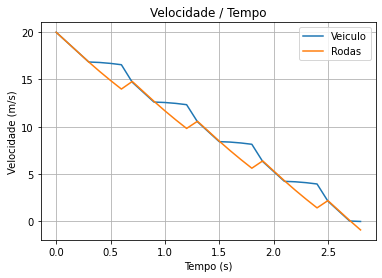

In [83]:
constantes_plot(a, b, c1, c2, dt, e, P, tau, time, vi)

### Função que declara as variaveis de cada estado

As variáveis são guardadas guardadas num dicionario $s$.
Sendo que representam:
> $s['T']$ ⟶ uma variável real com o tempo de execução do sistema;<br>
> $s['V']$ ⟶ uma variável real com o a velocidade do veículo;<br>
> $s['R']$ ⟶ uma variável real com o a velocidade das rodas;<br>
> $s['M']$ ⟶ uma constante que indica o modo do veículo (`Start`,  `Free`,  `Stopping`, `Blocked`, `Stopped`)<br>
> $s['Timer']$ ⟶ uma variavél real, utilizada nos modos `Free` e `Blocked`, para controlar o tempo de permanencia no modo.

In [8]:
def declare(i):
    s = {}
    s['T'] = Real('T'+str(i)) # tempo
    s['V'] = Real('V'+str(i)) # velociadae veiculo
    s['R'] = Real('R'+str(i)) # velocidade rodas
    s['M'] = Const('M'+str(i),Mode) # modo
    s['Timer'] = Real('Timer'+str(i))
    return s

### Função que adiciona as restrições do estado inicial

As restrições no estado inicial são:
> $T = 0 \quad \land\ \quad V = R = vi \quad \land\ \quad M = START$


In [9]:
def init(s):
    return And(s['T'] == 0, s['V'] == vi, s['R'] == vi, s['M'] == START) 

### Função que adiciona as restrições associadas a cada transição

Nesta função vamos definir as restrições para as transições entre os vários estados.<br>
Em primeiro lugar podemos divir as transições em dois grupos, ***timed*** e ***untimed***. Nas ***timed*** ocorre passagem de tempo e corresponde às transiçãoes de um estado para ele próprio, enquanto que nas transições ***untimed*** não ocorre passagem do tempo, correspondendo por isso a transições entre estados. A única excepção é a transição `Stopped` $ ⟶ $ `Stopped` que vai ser uma transição "untimed" apesar de ser uma transição de um estado para ele próprio.<br>

**Transições** ***untimed:***

- `Start` $ ⟶ $ `Stopping` <br>
> $M = START \land\ M' = STOPPING \land\ T = T' \land\ V = V' \land\ R = R'$ 
- `Stopping` $ ⟶ $ `Blocked` <br>
> $M = STOPPING \land\ M' = BLOCKED \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ V - R < e $
- `Blocked` $ ⟶ $ `Free` <br>
> $M = BLOCKED \land\ M' = FREE \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ Timer = tau \land\ Timer' = 0 $
- `Free` $ ⟶ $ `Stopping` <br>
> $M = FREE \land\ M' = STOPPING \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ Timer = tau$
- `Stopping` $ ⟶ $ `Stopped` <br>
> $M = STOPPING \land\ M' = STOPPED \land\ T = T' \land\ V' = 0 \land\ R' = 0 \land\ V < e \land\ R < e$<br>

**Nota:** A transição é feita com $V > 0 \land\ R > 0$ porque as restrições inerentes à transição `Stopping` $ ⟶ $ `Stopping` impedem que V e R atingam o valor 0 no estado `Stopping`.
- `Blocked` $ ⟶ $ `Stopped` <br>
> $M = BLOCKED \land\ M' = STOPPED \land\ T = T' \land\ V = V' \land\ R = R' \land\ V = 0 \land\ R = 0$<br>
- `Free` $ ⟶ $ `Stopped` <br>
> $M = FREE \land\ M' = STOPPED \land\ T = T' \land\ V = V' \land\ R = R' \land\ V = 0 \land\ R = 0$<br>
- `Stopped` $ ⟶ $ `Stopped` <br>
> $M = STOPPED \land\ M' = STOPPED \land\ T = T' \land\ V = V' \land\ R = R'$<br>

**Transições** ***timed:***

- `Stopping` $ ⟶ $ `Stopping` <br>
- `Blocked` $ ⟶ $ `Blocked` <br>
- `Free` $ ⟶ $ `Free` <br>


Seja $\ trans = [t_0,..,t_{i}]$, o conjunto de todas as transições definidas em cima.<br>

O resultado final é:
> $t_0 \ \vee ... \vee \ t_i $, com $ i\in trans$



In [20]:
def trans(s,p):
    granularidade = [i for i in range(vi+1)]
    
    #untimed
    
    
    start2stopping = And(s['M']==START, p['M']==STOPPING ,s['T']==p['T'], s['V']==p['V'], s['R']==p['R'])
    
    
    stopping2blocked = And(s['M']==STOPPING, p['M']==BLOCKED ,s['T']==p['T'], s['V']>0,s['R']>=0, 
                           s['V']==p['V'], s['R']==p['R'], p['Timer']==0, s['V']-s['R']<e)
    
    blocked2free = And(s['M']==BLOCKED, p['M']==FREE ,s['T']==p['T'],s['V']>0,s['R']>=0, 
                       s['V']==p['V'], s['R']==p['R'], s['Timer']==tau, 
                       p['Timer']==0)
    
    
    free2stopping  =  And(s['M']==FREE, p['M']==STOPPING ,s['T']==p['T'], s['V']>0,s['R']>=0, 
                          s['V']==p['V'], s['R']==p['R'], s['Timer']==tau)
    
    
    stopping2stopped = And(s['M']==STOPPING, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    free2stopped = And(s['M']==FREE, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']==0, s['R']==0, s['V']==p['V'], s['R']==p['R'])
    
    blocked2stopped = And(s['M']==BLOCKED, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']==0, s['R']==0, s['V']==p['V'], s['R']==p['R'])
    
    stopped2stopped = And(s['M']==STOPPED, p['M']==STOPPED, s['T'] == p['T'], 
                          s['V']==p['V'], s['R']== p['R'])
    
    
    
    #timed
    
    
    stopping2stopping = Or([And(s['M']==STOPPING,p['M']==STOPPING,p['T']>s['T'],
                        s['V']-s['R']>=e, p['V']-p['R']>=0,   
                        s['V']>=0,s['R']>=0, 
                        p['V']>=0, p['R']>=0,
                        s['V']-s['R']<i+0.5, s['V']-s['R']>=i-0.5, 
                        p['V']==(s['V']+(-c2*i-b)*(p['T']-s['T'])),
                        p['R']==(s['R']+(-a*P + c2*i)*(p['T']-s['T'])))for i in granularidade])
    
    
    
    free2free = Or([And(s['M']==FREE,p['M']==FREE,p['T']>s['T'], s['V']>=0,s['R']>=0,
                        p['V']>=0, p['R']>=0, 
                        p['Timer']<=tau,p['Timer']==s['Timer']+p['T']-s['T'], 
                        s['V']-s['R']<i+0.5, s['V']-s['R']>=i-0.5, 
                        p['V']==(s['V']+(-c1*i-b)*(p['T']-s['T'])),
                        p['R']==(s['R']+(-a*P + c1*i)*(p['T']-s['T'])))for i in granularidade])
    
    blocked2blocked = And(s['M']==BLOCKED,p['M']==BLOCKED,p['T']>s['T'],s['V']>=0,s['R']>=0,
                          p['V']>=0, p['R']>=0, 
                          p['Timer']<=tau,p['Timer']==s['Timer']+p['T']-s['T'],
                          p['V'] == s['V'] + (-a*P -b)*(p['T']-s['T']), 
                          p['R'] == s['R'] + (-a*P -b)*(p['T']-s['T'])) 
                          
    
    
    return Or( start2stopping, 
              stopping2blocked, blocked2free, free2stopping, stopping2stopped, free2stopped, blocked2stopped,
              stopping2stopping, free2free, blocked2blocked, stopped2stopped )

### Função que gera um traço de execução do sistema com k estados

A função vai simular, atravês do solver Z3, uma execução do sistema com **k** estados, $[E_0 .. E_{k-1}]$, e **k-1** transições, com as restrições codificadas anteriormente. Sendo $E_0$ o estado inicial. 

Caso o sistema seja satisfazivel, vão ser imprimidas, estado a estado, os valores das variáveis do sistema.

In [21]:
def gera_traco(declare,init,trans, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = declare(i)
    s.add(init(traco[0]))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if v!= "Timer":
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("Não ha execuções possiveis")
    else:
        print("Resultado impossivel de obter!")

In [84]:
gera_traco(declare,init,trans,10)

0
T = 0.0
V = 20.0
R = 20.0
M = START
1
T = 0.0
V = 20.0
R = 20.0
M = STOPPING
2
T = 0.0
V = 20.0
R = 20.0
M = BLOCKED
3
T = 0.2931578947368421
V = 16.921842105263156
R = 16.921842105263156
M = BLOCKED
4
T = 0.3
V = 16.85
R = 16.85
M = BLOCKED
5
T = 0.3
V = 16.85
R = 16.85
M = FREE
6
T = 0.3526315789473684
V = 16.823684210526316
R = 16.323684210526316
M = FREE
7
T = 0.5871207430340557
V = 16.589195046439627
R = 14.096037151702786
M = FREE
8
T = 0.6
V = 16.569876160990713
R = 13.980123839009288
M = FREE
9
T = 0.6
V = 16.569876160990713
R = 13.980123839009288
M = STOPPING


### Função que gera um traço de execução do sistema com k estados e com garantia que o automóvel se imobiliza

A função é praticamente igual à função ***gera_traco***, definida anteriormente, sendo que nesta vai ser adicionada a seguinte restrição ao estado final ($E_{k-1}$):
> $M = STOPPED$

Para que o resultado de execução da função seja satisfazivel, temos que ir testando para vários valores de **k**, uma vez que para um valor de **k** demasiado pequeno, o número de estados disponivies pode ser insuficiente para conseguir imobilizar o veículo.

In [22]:
def gera_traco_stopped(declare,init,trans, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = declare(i)
    s.add(init(traco[0]))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    s.add(traco[k-1]['M']==STOPPED) 
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if v!= "Timer":
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("Não ha execuções possiveis")
    else:
        print("Resultado impossivel de obter!")

In [23]:
gera_traco_stopped(declare,init,trans,40)

0
T = 0.0
V = 20.0
R = 20.0
M = START
1
T = 0.0
V = 20.0
R = 20.0
M = STOPPING
2
T = 0.0
V = 20.0
R = 20.0
M = BLOCKED
3
T = 0.3
V = 16.85
R = 16.85
M = BLOCKED
4
T = 0.3
V = 16.85
R = 16.85
M = FREE
5
T = 0.6
V = 16.7
R = 13.85
M = FREE
6
T = 0.6
V = 16.7
R = 13.85
M = STOPPING
7
T = 0.6415598290598291
V = 15.806463675213676
R = 14.30715811965812
M = STOPPING
8
T = 0.6422542735042736
V = 15.801255341880342
R = 14.305074786324786
M = STOPPING
9
T = 0.642948717948718
V = 15.796047008547008
R = 14.302991452991453
M = STOPPING
10
T = 0.6436431623931624
V = 15.790838675213676
R = 14.30090811965812
M = STOPPING
11
T = 0.6443376068376069
V = 15.785630341880342
R = 14.298824786324786
M = STOPPING
12
T = 0.6450320512820513
V = 15.780422008547008
R = 14.296741452991453
M = STOPPING
13
T = 0.6457264957264958
V = 15.775213675213676
R = 14.29465811965812
M = STOPPING
14
T = 0.6464209401709402
V = 15.770005341880342
R = 14.292574786324787
M = STOPPING
15
T = 0.6471153846153846
V = 15.76479700854700

## Verificação das propriedades

### Codificação das propriedades

Para garantir a proprieade A, o veículo imobiliza-se completamente em menos de  𝑡  segundos, temos que adicionar ao estdo final a seguinte restrição:
> $T \ge t \implies\ M = STOPPED \ \vee \ (V \le 0 \land\ R \le 0)$


Para garantir a proprieade B, a velocidade  𝑉  diminui sempre com o tempo, temos que adicionar a cada transição a seguinte restrição:
> $T < T'  \implies\ V > V'$   

In [27]:
def propA(state):
    return Implies(state['T']>=time, Or(state['M']==STOPPED,And(state['V']<=0,state['R']<=0)))

def propB(pre,pos):
    return Implies(pre['T']<pos['T'],pre['V']>pos['V'])

### Função que testa as propriedades com Bounded Model Checking

Para garantir as propriedades vamos utilizar o solver do Z3, num processo iterativo com **K** iterações,$[k_1 .. k_K]$. Assim sendo, em cada uma das iterações vamos, atravês do solver, simular uma execução do sistema tal como é feito na função ***gera_traco***, com a diferença que agora vamos adicionar as restrições que garantem as propriedades A e B<br>
Sejam: 
- $\ trans = [t_i,..,t_{k-1}]$, o conjunto das transições em cada interação **k** da função;<br>
- $\ E = [e_0,..,e_{k-1}]$, o conjunto dos estados em cada interação **k**.<br>

A restrição adionada para garantir as propriedade A e B é:
> $(\forall_{i\in trans} \ \neg Propriedade B(t_{i-1},t_i)) \quad \vee  \quad \neg Propriedade A(e_{k-1})$

Caso em alguma das iterações o resultado seja satisfazivel, são imprimidos os valores da variáveis nessa execução do sistema e a função termina. Neste cenário, podemos concluir que pelos menos uma das propriedades A ou B não é respeitada.<br>

Caso o resultado nunca seja satisfazivel ao longo das **K** interações, significa que as propriedades A e B nessas execuções do sistema foram sempre respeitadas e podemos concluir que as propriedades "podem" ser verdadeiras.

In [25]:
def bmc_always(declare,init,trans,invA,invB,K):
    for k in range(1, K+1):
        s = Solver()
        traco = {}
        for i in range(k):
            traco[i] = declare(i)
        s.add(init(traco[0]))
        invs = []
        for i in range(k-1):
            s.add(trans(traco[i],traco[i+1]))
            invs.append(Not(invB(traco[i],traco[i+1])))
        invs.append(Not(invA(traco[k-1])))
        s.add(Or(invs))
        status = s.check()
        if status == sat:
            m = s.model()
            for i in range(k):
                print(i)
                for v in traco[i]:
                    if v!= "Timer":
                        if traco[i][v].sort() == RealSort():
                            print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                        else:
                            print(v,"=",m[traco[i][v]])
            return
    print("As propriedades podem ser verdadeiras...")

### Teste das propriedades

In [28]:
bmc_always(declare,init,trans,propA,propB,15)

As propriedades podem ser verdadeiras...
